# Identifying the Optimal locations for the ATM coverage area using clustering algorithm

## Overview

Identifying the correct ATM location is a problem of critical importance and optimizing business operations without affecting customer service is very challenging for the banks. In the case of banking services, the location of ATMs must match the service demands (turnaround time for service, accessibility etc) of the customers. Therefore, it is necessary to analyse the geographical data of neighbourhoods so as to reflect the customers' convenience and tolerance for quality of service in a given geographical region.

## Scope

The project scope is to suggest the neighbourhoods for establishing the ATM in the Toronto city based on the foursquare public API and census data. 

## Approach

I propose to utilize the density based clustering algorithm (K-Means) to segment the neighbourhoods based on the location demographics and the preferences for ATM location among customers utilizing the ATM services. 
I will have three datasources: 

1. I will retrieve Foursquare data from their Public API

2. I will use the census block dataset from the data portal for the country Canada

3. Geospatial data for each postal code

I would join the data from all the above mentioned sources and clean them for the consumption. I will perform clustering on these data and propose to use the DBSCAN algorithms to cluster the locations. Using the Numerical Heatmap, I would be able to characterize our clusters and rename them accordingly.

Using the clusters and their characteristics,  i would propose the neighbourhoods for establishing the ATM's 

## Source of Data

Data for Postal codes is downloaded from the Wikipedia website and data for population from Statistics Canada, the national statistical agency.

In [1]:
import pandas as pd

data downloaded from wiki page for Postal codes

In [ ]:
data = pd.read_html("https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M")
df=data[0]

In [3]:
df.head()


,Postal Code,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"


Population data from the statistics Canada

In [4]:
data1 = pd.read_html("https://www12.statcan.gc.ca/census-recensement/2016/dp-pd/hlt-fst/pd-pl/Table.cfm?Lang=Eng&T=1201&SR=1&S=22&O=A&RPP=9999&PR=0", header = 0, skiprows = [1,2])
df1=data1[0]

In [5]:
df1.head()
df1.drop(columns=['Total private dwellings, 2016', 'Private dwellings occupied by usual residents, 2016'],inplace = True)
df1.rename(columns={'Geographic name':'Postal Code', 'Population,2016':'Population'})
df1.head()                        

,Geographic name,"Population, 2016"
0,A0A,46587
1,A0B,19792
2,A0C,12587
3,A0E,22294
4,A0G,35266


In [6]:
df1.rename(columns={'Geographic name':'Postal Code', 'Population, 2016':'Population'}, inplace=True)
df1.head()  

,Postal Code,Population
0,A0A,46587
1,A0B,19792
2,A0C,12587
3,A0E,22294
4,A0G,35266


In [7]:
df_Borough_NA = df[df ['Borough']== 'Not assigned'].index
df_refined1 = df.drop(df_Borough_NA , inplace=False)
df_refined1.reset_index(drop = True, inplace=True)
df_refined1.head()


,Postal Code,Borough,Neighbourhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


In [8]:
df_refined1.shape

(103, 3)

In [9]:
df1.shape

(1641, 2)

Merging the two data based on Postal codes

In [10]:
df_merged=pd.merge(df1,df_refined1, on='Postal Code', how='inner')

In [11]:
df_merged.shape

(102, 4)

In [12]:
df_merged.head()

,Postal Code,Population,Borough,Neighbourhood
0,M1B,66108,Scarborough,"Malvern, Rouge"
1,M1C,35626,Scarborough,"Rouge Hill, Port Union, Highland Creek"
2,M1E,46943,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,29690,Scarborough,Woburn
4,M1H,24383,Scarborough,Cedarbrae


In [13]:

df_merged.loc[(df_merged.Neighbourhood == 'Not assigned'),'Neighbourhood']= df_merged['Borough']

In [14]:
df_merged.head()

,Postal Code,Population,Borough,Neighbourhood
0,M1B,66108,Scarborough,"Malvern, Rouge"
1,M1C,35626,Scarborough,"Rouge Hill, Port Union, Highland Creek"
2,M1E,46943,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,29690,Scarborough,Woburn
4,M1H,24383,Scarborough,Cedarbrae


Getting the Geo Spatial data for each Postal code and merging with remaining data

In [14]:
df_latlongdata = pd.read_csv("http://cocl.us/Geospatial_data",error_bad_lines=False)
df_latlongdata.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [15]:
df_refined2=pd.merge(df_merged, df_latlongdata, on="Postal Code")
df_refined2.head()

,Postal Code,Population,Borough,Neighbourhood,Latitude,Longitude
0,M1B,66108,Scarborough,"Malvern, Rouge",43.806686,-79.194353
1,M1C,35626,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497
2,M1E,46943,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,29690,Scarborough,Woburn,43.770992,-79.216917
4,M1H,24383,Scarborough,Cedarbrae,43.773136,-79.239476


In [16]:
df_refined2.shape

(102, 6)

In [17]:
df_refined2.dtypes

Postal Code       object
Population         int64
Borough           object
Neighbourhood     object
Latitude         float64
Longitude        float64
dtype: object

## Venues and Categories

The venues and Categories arranged based on Foursquare Data. Total primary categories are determined and their count for each postal code is calculated by scrubbing the data from Foursquare web site.

In [42]:
CLIENT_ID = 'EGJKQDYKTK1C4M0FZWMMJKGMQMDJ5UCVB3JXMR4HK2SAIO3B' # your Foursquare ID
CLIENT_SECRET = 'MGHTUD1KFO44R5JZZKZO1XPTJYOS5WN3NJAOUE4KHXXG34I3' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: EGJKQDYKTK1C4M0FZWMMJKGMQMDJ5UCVB3JXMR4HK2SAIO3B
CLIENT_SECRET:MGHTUD1KFO44R5JZZKZO1XPTJYOS5WN3NJAOUE4KHXXG34I3


In [19]:
!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim


Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    openssl-1.1.1g             |       h516909a_1         2.1 MB  conda-forge
    certifi-2020.6.20          |   py36h9f0ad1d_0         151 KB  conda-forge
    python_abi-3.6             |          1_cp36m           4 KB  conda-forge
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    ca-certificates-2020.6.20  |       hecda079_0         145 KB  conda-forge
    geopy-2.0.0                |     pyh9f0ad1d_0          63 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.5 MB

The following NEW packages will be INSTALLED:

    geographiclib:   1.50-py_0          conda-forge
    geopy:           

In [20]:
address = 'Toronto, Ontario'

geolocator = Nominatim(user_agent="toronto_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto,Ontario are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto,Ontario are 43.6534817, -79.3839347.


In [21]:
!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    branca-0.4.1               |             py_0          26 KB  conda-forge
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    folium-0.5.0               |             py_0          45 KB  conda-forge
    altair-4.1.0               |             py_1         614 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         713 KB

The following NEW packages will be INSTALLED:

    altair:  4.1.0-py_1 conda-forge
    branca:  0.4.1-py_0 conda-forge
    folium:  0.5.0-py_0 conda-forge
    vincent: 0.4.4-py_1 conda-forge


branca-0.4.1         | 26 KB     | ##################################### | 1

In [219]:
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(df_refined2['Latitude'], df_refined2['Longitude'], df_refined2['Neighbourhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

In [23]:
import json
! pip install requests
import requests # library to handle requests
from pandas.io.json import json_normalize

Calling Foursquare API to get all the categories and hierachy for the venues

In [26]:
categories_url = 'https://api.foursquare.com/v2/venues/categories?client_id={}&client_secret={}&v={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
            
# make the GET request
results = requests.get(categories_url).json()

In [27]:
print(results)

{'meta': {'code': 200, 'requestId': '5f37a50f0570a56adc94d7e6'}, 'response': {'categories': [{'id': '4d4b7104d754a06370d81259', 'name': 'Arts & Entertainment', 'pluralName': 'Arts & Entertainment', 'shortName': 'Arts & Entertainment', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/arts_entertainment/default_', 'suffix': '.png'}, 'categories': [{'id': '56aa371be4b08b9a8d5734db', 'name': 'Amphitheater', 'pluralName': 'Amphitheaters', 'shortName': 'Amphitheater', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/arts_entertainment/default_', 'suffix': '.png'}, 'categories': []}, {'id': '4fceea171983d5d06c3e9823', 'name': 'Aquarium', 'pluralName': 'Aquariums', 'shortName': 'Aquarium', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/arts_entertainment/aquarium_', 'suffix': '.png'}, 'categories': []}, {'id': '4bf58dd8d48988d1e1931735', 'name': 'Arcade', 'pluralName': 'Arcades', 'shortName': 'Arcade', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/a

Making the list of Categories from the foursquare API 

In [28]:
categories_list = []
# Let's print only the top-level categories and their IDs and also add them to categories_list

def print_categories(categories, level=0, max_level=0):    
    if level>max_level: return
    out = ''
    out += '-'*level
    for category in categories:
        print(out + category['name'] + ' (' + category['id'] + ')')
        print_categories(category['categories'], level+1, max_level)
        categories_list.append((category['name'], category['id']))
        
print_categories(results['response']['categories'], 0, 0)


Arts & Entertainment (4d4b7104d754a06370d81259)
College & University (4d4b7105d754a06372d81259)
Event (4d4b7105d754a06373d81259)
Food (4d4b7105d754a06374d81259)
Nightlife Spot (4d4b7105d754a06376d81259)
Outdoors & Recreation (4d4b7105d754a06377d81259)
Professional & Other Places (4d4b7105d754a06375d81259)
Residence (4e67e38e036454776db1fb3a)
Shop & Service (4d4b7105d754a06378d81259)
Travel & Transport (4d4b7105d754a06379d81259)


Function for getting the counts in each category for the venues in across the Postal Codes 

In [29]:
def get_venues_count(ll, radius, categoryId):
    explore_url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={}&radius={}&categoryId={}'.format(
                CLIENT_ID, 
                CLIENT_SECRET, 
                VERSION,
                ll,
                radius,
                categoryId)

    # make the GET request
    return requests.get(explore_url).json()['response']['totalResults']

In [30]:
df_refined2['Coordinates']=df_refined2['Latitude'].astype(str) + "," + df_refined2['Longitude'].astype(str) 

In [31]:
df_refined2.head()

,Postal Code,Population,Borough,Neighbourhood,Latitude,Longitude,Coordinates
0,M1B,66108,Scarborough,"Malvern, Rouge",43.806686,-79.194353,"43.806686299999996,-79.19435340000001"
1,M1C,35626,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497,"43.7845351,-79.16049709999999"
2,M1E,46943,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711,"43.7635726,-79.1887115"
3,M1G,29690,Scarborough,Woburn,43.770992,-79.216917,"43.7709921,-79.21691740000001"
4,M1H,24383,Scarborough,Cedarbrae,43.773136,-79.239476,"43.773136,-79.23947609999999"


In [32]:
df_refined2.shape
df_refined2.dtypes

Postal Code       object
Population         int64
Borough           object
Neighbourhood     object
Latitude         float64
Longitude        float64
Coordinates       object
dtype: object

In [33]:
#Create new dataframe to store venues data
df_refined3 = df_refined2.copy()
for c in categories_list:
    df_refined3[c[0]] = 0

In [34]:
df_refined3.shape

(102, 17)

In [35]:
df_refined3.drop(df_refined2.index[48])

,Postal Code,Population,Borough,Neighbourhood,Latitude,Longitude,Coordinates,Arts & Entertainment,College & University,Event,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport
0,M1B,66108,Scarborough,"Malvern, Rouge",43.806686,-79.194353,"43.806686299999996,-79.19435340000001",0,0,0,0,0,0,0,0,0,0
1,M1C,35626,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497,"43.7845351,-79.16049709999999",0,0,0,0,0,0,0,0,0,0
2,M1E,46943,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711,"43.7635726,-79.1887115",0,0,0,0,0,0,0,0,0,0
3,M1G,29690,Scarborough,Woburn,43.770992,-79.216917,"43.7709921,-79.21691740000001",0,0,0,0,0,0,0,0,0,0
4,M1H,24383,Scarborough,Cedarbrae,43.773136,-79.239476,"43.773136,-79.23947609999999",0,0,0,0,0,0,0,0,0,0
5,M1J,36699,Scarborough,Scarborough Village,43.744734,-79.239476,"43.7447342,-79.23947609999999",0,0,0,0,0,0,0,0,0,0
6,M1K,48434,Scarborough,"Kennedy Park, Ionview, East Birchmount Park",43.727929,-79.262029,"43.7279292,-79.26202940000002",0,0,0,0,0,0,0,0,0,0
7,M1L,35081,Scarborough,"Golden Mile, Clairlea, Oakridge",43.711112,-79.284577,"43.711111700000004,-79.2845772",0,0,0,0,0,0,0,0,0,0
8,M1M,22913,Scarborough,"Cliffside, Cliffcrest, Scarborough Village West",43.716316,-79.239476,"43.716316,-79.23947609999999",0,0,0,0,0,0,0,0,0,0
9,M1N,22136,Scarborough,"Birch Cliff, Cliffside West",43.692657,-79.264848,"43.692657000000004,-79.2648481",0,0,0,0,0,0,0,0,0,0


In [36]:
df_refined3.shape

(102, 17)

In [44]:
for i, row in df_refined3.iterrows():
    print(i)
    for c in categories_list:        
        df_refined3.loc[i, c[0]] = get_venues_count(df_refined3.Coordinates.iloc[i], radius=500, categoryId=c[1])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92


KeyError: 'totalResults'

In [45]:
df_refined3.to_csv('PostalCode_venues.csv')

In [174]:

#Read already stored CSV
PostalCode_venues_df = pd.read_csv('PostalCode_venues.csv', index_col=0)
PostalCode_venues_df.head()

,Postal Code,Population,Borough,Neighbourhood,Latitude,Longitude,Coordinates,Arts & Entertainment,College & University,Event,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport
0,M1B,66108,Scarborough,"Malvern, Rouge",43.806686,-79.194353,"43.806686299999996,-79.19435340000001",0,0,0,2,0,0,7,0,12,0
1,M1C,35626,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497,"43.7845351,-79.16049709999999",1,0,0,0,1,1,3,0,3,1
2,M1E,46943,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711,"43.7635726,-79.1887115",0,1,0,5,0,2,4,0,3,4
3,M1G,29690,Scarborough,Woburn,43.770992,-79.216917,"43.7709921,-79.21691740000001",0,0,0,3,0,1,2,0,3,0
4,M1H,24383,Scarborough,Cedarbrae,43.773136,-79.239476,"43.773136,-79.23947609999999",0,1,0,5,1,8,2,0,15,0


In [175]:
PostalCode_venues_df1= PostalCode_venues_df.drop(columns=['Borough','Neighbourhood','Latitude','Longitude','Coordinates','Population'] )
PostalCode_venues_df2= PostalCode_venues_df.drop(columns=['Borough','Neighbourhood','Coordinates','Latitude','Longitude'] )

In [187]:
PostalCode_venues_df2.head()

,Postal Code,Population,Arts & Entertainment,College & University,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Shop & Service,Travel & Transport
0,M1B,66108,0,0,2,0,0,7,12,0
1,M1C,35626,1,0,0,1,1,3,3,1
2,M1E,46943,0,1,5,0,2,4,3,4
3,M1G,29690,0,0,3,0,1,2,3,0
4,M1H,24383,0,1,5,1,8,2,15,0


In [177]:
import matplotlib.pyplot as plt
import seaborn as sns

Making boxplot diagrams for each of the categories.Events and Residence has minimal data so dropping from the list of parameters.

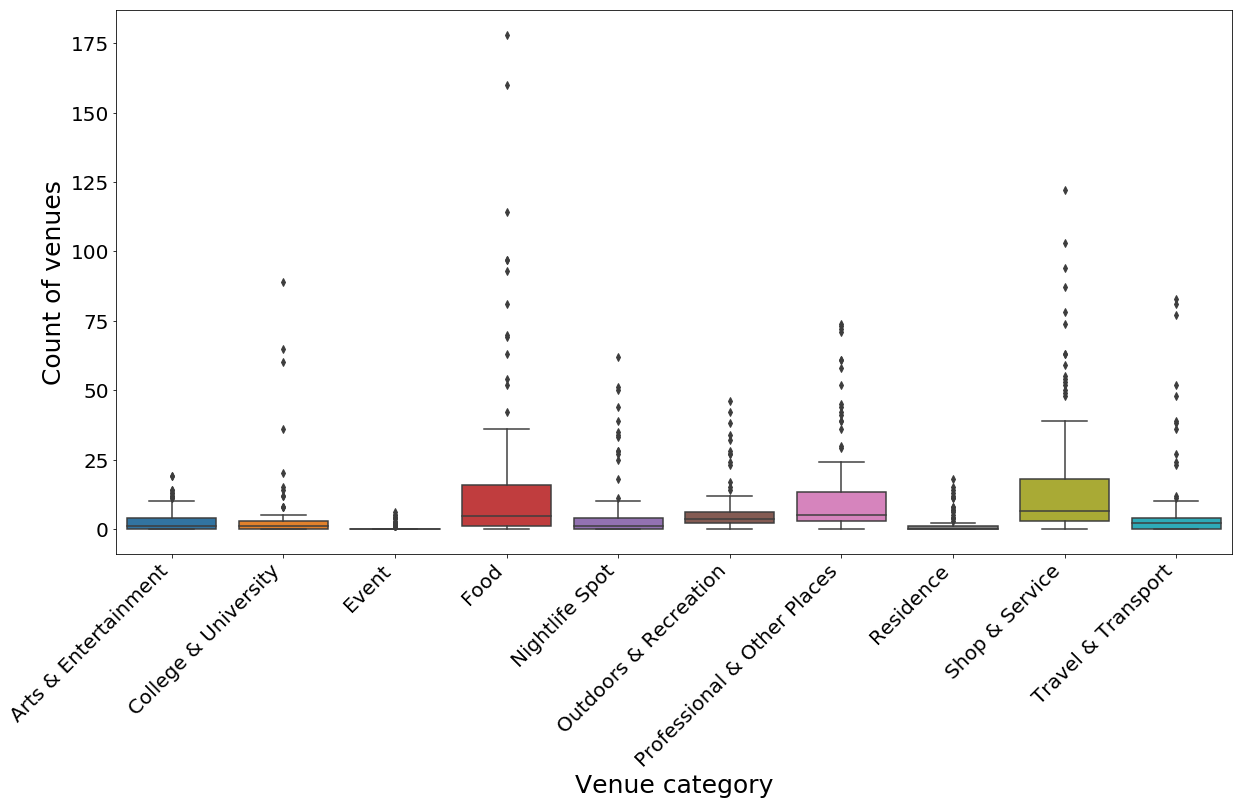

In [178]:
plt.figure(figsize=(20, 10))
plt.xticks(rotation='vertical')
sns.boxplot

ax = sns.boxplot(data = PostalCode_venues_df1)
ax.set_ylabel('Count of venues', fontsize=25)
ax.set_xlabel('Venue category', fontsize=25)
ax.tick_params(labelsize=20)
plt.xticks(rotation=45, ha='right')

plt.show()

In [179]:
PostalCode_venues_df2.drop('Event', 1, inplace=True)

In [180]:
PostalCode_venues_df2.drop('Residence', 1, inplace=True)

In [181]:
categories_list = list(filter(lambda x: x[0] != 'Event', categories_list))

In [182]:
categories_list = list(filter(lambda x: x[0] != 'Residence', categories_list))

In [183]:
from sklearn.cluster import KMeans

Doing the normalization of the data using standard scaler functionality

In [188]:
from sklearn.preprocessing import MinMaxScaler

X = PostalCode_venues_df2.values[:,1:]
cluster_dataset = MinMaxScaler().fit_transform(X)

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [189]:
print(cluster_dataset)

[[8.71022570e-01 0.00000000e+00 0.00000000e+00 1.12359551e-02
  0.00000000e+00 0.00000000e+00 9.45945946e-02 9.83606557e-02
  0.00000000e+00]
 [4.69399317e-01 5.26315789e-02 0.00000000e+00 0.00000000e+00
  1.61290323e-02 2.17391304e-02 4.05405405e-02 2.45901639e-02
  1.20481928e-02]
 [6.18509295e-01 0.00000000e+00 1.12359551e-02 2.80898876e-02
  0.00000000e+00 4.34782609e-02 5.40540541e-02 2.45901639e-02
  4.81927711e-02]
 [3.91188057e-01 0.00000000e+00 0.00000000e+00 1.68539326e-02
  0.00000000e+00 2.17391304e-02 2.70270270e-02 2.45901639e-02
  0.00000000e+00]
 [3.21264345e-01 0.00000000e+00 1.12359551e-02 2.80898876e-02
  1.61290323e-02 1.73913043e-01 2.70270270e-02 1.22950820e-01
  0.00000000e+00]
 [4.83536899e-01 0.00000000e+00 0.00000000e+00 5.61797753e-03
  0.00000000e+00 2.17391304e-02 6.75675676e-02 3.27868852e-02
  0.00000000e+00]
 [6.38154341e-01 5.26315789e-02 1.12359551e-02 1.68539326e-02
  0.00000000e+00 4.34782609e-02 6.75675676e-02 5.73770492e-02
  3.61445783e-02]
 [4.62

Drawing the box plot diagram for each category using the normalized data

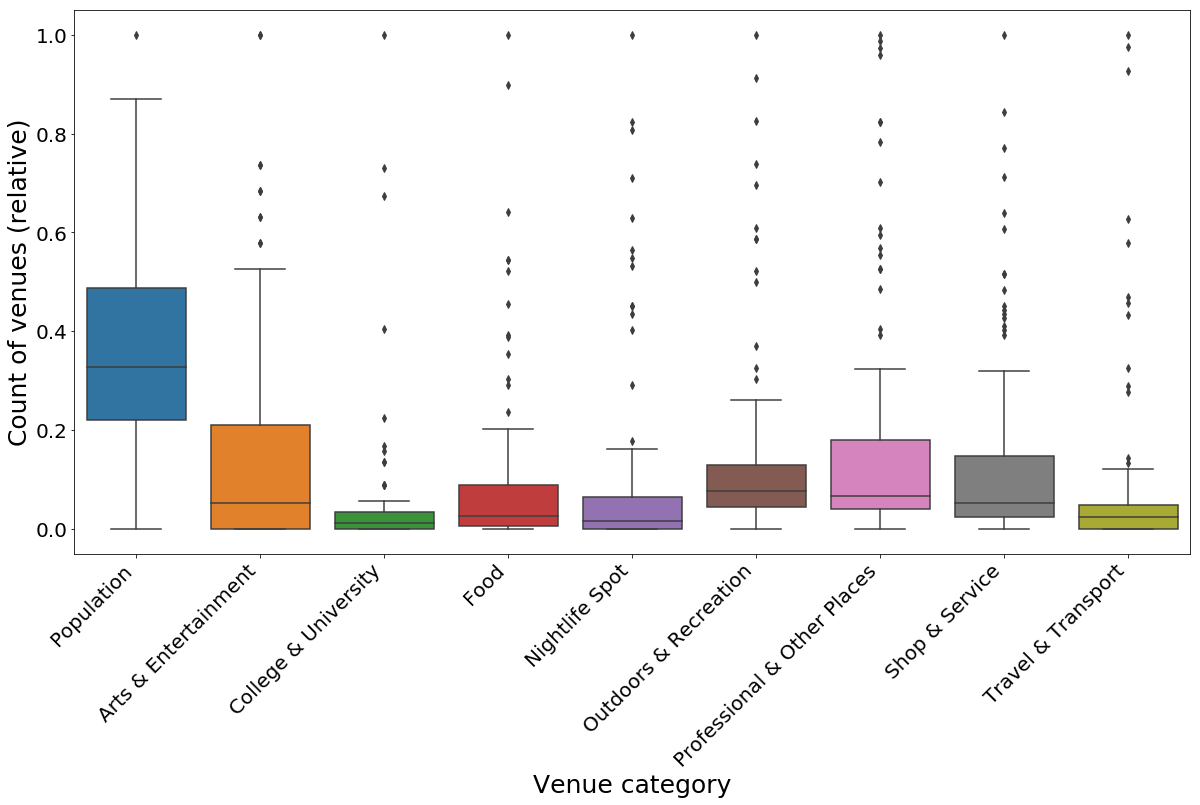

In [194]:
plt.figure(figsize=(20, 10))
#plt.xticks(rotation='vertical')
sns.boxplot

ax = sns.boxplot(data = cluster_df)
ax.set_ylabel('Count of venues (relative)', fontsize=25)
ax.set_xlabel('Venue category', fontsize=25)
ax.tick_params(labelsize=20)
plt.xticks(rotation=45, ha='right')

plt.show()

In [191]:
cluster_df = pd.DataFrame(cluster_dataset)


In [192]:
cluster_df.shape

(102, 9)

In [193]:
cluster_df.columns = ['Population', 'Arts & Entertainment', 'College & University', 'Food', 'Nightlife Spot', 'Outdoors & Recreation', 'Professional & Other Places', 'Shop & Service', 'Travel & Transport']

In [195]:
cluster_df.head()

,Population,Arts & Entertainment,College & University,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Shop & Service,Travel & Transport
0,0.871023,0.000000,0.000000,0.011236,0.000000,0.000000,0.094595,0.098361,0.000000
1,0.469399,0.052632,0.000000,0.000000,0.016129,0.021739,0.040541,0.024590,0.012048
2,0.618509,0.000000,0.011236,0.028090,0.000000,0.043478,0.054054,0.024590,0.048193
3,0.391188,0.000000,0.000000,0.016854,0.000000,0.021739,0.027027,0.024590,0.000000
4,0.321264,0.000000,0.011236,0.028090,0.016129,0.173913,0.027027,0.122951,0.000000


## K-Means Clustering

We'll be using k-means clustering. These were preliminary results with different number of clusters:

After analysing the data with different cluster sizes, we decided to settle with 4 clusters.
For the final analysis let's settle on 4 clusters.

In [215]:
kclusters = 4

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(cluster_df)

kmeans_labels = kmeans.labels_

In [211]:
print(kmeans_labels)

[3 3 3 0 0 3 3 3 0 0 3 0 3 3 3 3 0 0 2 0 0 3 3 0 3 3 0 3 3 0 0 0 0 3 0 0 3
 0 0 0 3 3 3 0 0 0 0 0 0 0 0 0 2 2 4 1 2 4 1 1 1 1 0 0 0 0 4 2 3 1 1 0 0 0
 3 3 3 2 3 0 3 3 3 0 3 4 0 3 0 0 0 0 3 3 3 0 0 0 0 3 3 3]


In [218]:
PostalCode_venues_df.drop(['Cluster Labels'], axis=1)
PostalCode_venues_df.insert(0, 'Cluster Labels', kmeans.labels_)
PostalCode_venues_df.head(5)

ValueError: cannot insert Cluster Labels, already exists

In [199]:
import matplotlib.cm as cm
import matplotlib.colors as colors

In [201]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(PostalCode_venues_df['Latitude'], PostalCode_venues_df['Longitude'], PostalCode_venues_df['Neighbourhood'], PostalCode_venues_df['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [205]:

PostalCode_venues_df.loc[PostalCode_venues_df['Cluster Labels'] == 0, PostalCode_venues_df.columns[[1] + list(range(2, PostalCode_venues_df.shape[1]))]]

,Postal Code,Population,Borough,Neighbourhood,Latitude,Longitude,Coordinates,Arts & Entertainment,College & University,Event,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport
18,M2J,58293,North York,"Fairview, Henry Farm, Oriole",43.778517,-79.346556,"43.7785175,-79.3465557",5,3,0,29,3,2,14,4,122,6
43,M4M,24689,East Toronto,Studio District,43.659526,-79.340923,"43.6595255,-79.340923",2,1,0,25,10,17,29,0,34,4
52,M4Y,30472,Downtown Toronto,Church and Wellesley,43.665860,-79.383160,"43.6658599,-79.38315990000001",13,15,3,63,27,28,39,18,63,24
53,M5A,41078,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,"43.6542599,-79.3606359",13,4,4,23,11,9,42,4,48,10
56,M5E,9118,Downtown Toronto,Berczy Park,43.644771,-79.373306,"43.644770799999996,-79.3733064",8,5,0,52,28,15,45,11,52,23
57,M5G,8423,Downtown Toronto,Central Bay Street,43.657952,-79.387383,"43.6579524,-79.3873826",6,36,4,70,18,24,61,14,54,27
66,M5S,15372,Downtown Toronto,"University of Toronto, Harbord",43.662696,-79.400049,"43.6626956,-79.4000493",5,89,2,32,7,8,24,3,13,3
67,M5T,17748,Downtown Toronto,"Kensington Market, Chinatown, Grange Park",43.653206,-79.400049,"43.6532057,-79.4000493",8,3,1,54,25,10,36,5,78,11
77,M6J,32684,West Toronto,"Little Portugal, Trinity",43.647927,-79.419750,"43.647926700000006,-79.4197497",14,5,1,42,28,12,10,2,55,1
85,M7A,10,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,"43.6623015,-79.3894938",5,60,4,28,9,14,52,12,53,9


In [206]:
PostalCode_venues_df.loc[PostalCode_venues_df['Cluster Labels'] == 1, PostalCode_venues_df.columns[[1] + list(range(2, PostalCode_venues_df.shape[1]))]]

,Postal Code,Population,Borough,Neighbourhood,Latitude,Longitude,Coordinates,Arts & Entertainment,College & University,Event,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport
3,M1G,29690,Scarborough,Woburn,43.770992,-79.216917,"43.7709921,-79.21691740000001",0,0,0,3,0,1,2,0,3,0
4,M1H,24383,Scarborough,Cedarbrae,43.773136,-79.239476,"43.773136,-79.23947609999999",0,1,0,5,1,8,2,0,15,0
8,M1M,22913,Scarborough,"Cliffside, Cliffcrest, Scarborough Village West",43.716316,-79.239476,"43.716316,-79.23947609999999",1,0,0,1,0,1,5,0,0,3
9,M1N,22136,Scarborough,"Birch Cliff, Cliffside West",43.692657,-79.264848,"43.692657000000004,-79.2648481",0,3,0,4,4,2,2,0,2,0
11,M1R,29858,Scarborough,"Wexford, Maryvale",43.750071,-79.295849,"43.750071500000004,-79.2958491",0,0,0,6,1,1,0,0,4,0
16,M1X,15097,Scarborough,Upper Rouge,43.836125,-79.205636,"43.836124700000006,-79.20563609999999",0,0,0,0,0,0,0,0,0,0
17,M2H,24497,North York,Hillcrest Village,43.803762,-79.363452,"43.8037622,-79.3634517",0,1,0,2,0,4,2,0,0,0
19,M2K,23852,North York,Bayview Village,43.786947,-79.385975,"43.7869473,-79.385975",2,0,0,3,0,3,5,0,4,0
20,M2L,11717,North York,"York Mills, Silver Hills",43.757490,-79.374714,"43.7574902,-79.37471409999999",0,0,0,1,0,2,4,0,0,0
23,M2P,7843,North York,York Mills West,43.752758,-79.400049,"43.752758299999996,-79.4000493",0,1,0,0,1,3,4,0,4,1


In [207]:
PostalCode_venues_df.loc[PostalCode_venues_df['Cluster Labels'] == 2, PostalCode_venues_df.columns[[1] + list(range(2, PostalCode_venues_df.shape[1]))]]

,Postal Code,Population,Borough,Neighbourhood,Latitude,Longitude,Coordinates,Arts & Entertainment,College & University,Event,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport
54,M5B,12785,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937,"43.6571618,-79.37893709999999",12,65,2,97,35,27,41,8,103,36
55,M5C,2951,Downtown Toronto,St. James Town,43.651494,-79.375418,"43.6514939,-79.3754179",14,14,0,69,39,27,73,11,94,39
58,M5H,2005,Downtown Toronto,"Richmond, Adelaide, King",43.650571,-79.384568,"43.65057120000001,-79.3845675",19,20,2,93,33,46,61,7,87,38
59,M5J,14545,Downtown Toronto,"Harbourfront East, Union Station, Toronto Islands",43.640816,-79.381752,"43.6408157,-79.38175229999999",19,2,6,81,34,42,39,15,38,52
60,M5K,0,Downtown Toronto,"Toronto Dominion Centre, Design Exchange",43.647177,-79.381576,"43.6471768,-79.38157640000001",11,8,5,114,50,34,71,6,74,81
61,M5L,0,Downtown Toronto,"Commerce Court, Victoria Hotel",43.648198,-79.379817,"43.6481985,-79.37981690000001",10,12,5,178,62,32,72,8,59,83
69,M5W,15,Downtown Toronto,Stn A PO Boxes,43.646435,-79.374846,"43.6464352,-79.37484599999999",12,8,2,97,44,23,58,13,50,48
70,M5X,10,Downtown Toronto,"First Canadian Place, Underground city",43.648429,-79.382280,"43.6484292,-79.3822802",11,12,4,160,51,38,74,7,63,77


In [208]:
PostalCode_venues_df.loc[PostalCode_venues_df['Cluster Labels'] == 3, PostalCode_venues_df.columns[[1] + list(range(2, PostalCode_venues_df.shape[1]))]]

,Postal Code,Population,Borough,Neighbourhood,Latitude,Longitude,Coordinates,Arts & Entertainment,College & University,Event,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport
0,M1B,66108,Scarborough,"Malvern, Rouge",43.806686,-79.194353,"43.806686299999996,-79.19435340000001",0,0,0,2,0,0,7,0,12,0
1,M1C,35626,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497,"43.7845351,-79.16049709999999",1,0,0,0,1,1,3,0,3,1
2,M1E,46943,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711,"43.7635726,-79.1887115",0,1,0,5,0,2,4,0,3,4
5,M1J,36699,Scarborough,Scarborough Village,43.744734,-79.239476,"43.7447342,-79.23947609999999",0,0,0,1,0,1,5,0,4,0
6,M1K,48434,Scarborough,"Kennedy Park, Ionview, East Birchmount Park",43.727929,-79.262029,"43.7279292,-79.26202940000002",1,1,0,3,0,2,5,0,7,3
7,M1L,35081,Scarborough,"Golden Mile, Clairlea, Oakridge",43.711112,-79.284577,"43.711111700000004,-79.2845772",2,0,0,5,0,4,5,0,5,3
10,M1P,45571,Scarborough,"Dorset Park, Wexford Heights, Scarborough Town...",43.757410,-79.273304,"43.7574096,-79.27330400000001",1,0,0,4,1,3,3,0,9,2
12,M1S,37769,Scarborough,Agincourt,43.794200,-79.262029,"43.7942003,-79.26202940000002",0,0,1,3,1,4,5,0,3,1
13,M1T,34588,Scarborough,"Clarks Corners, Tam O'Shanter, Sullivan",43.781638,-79.304302,"43.7816375,-79.3043021",0,2,0,8,0,3,10,1,7,3
14,M1V,54680,Scarborough,"Milliken, Agincourt North, Steeles East, L'Amo...",43.815252,-79.284577,"43.8152522,-79.2845772",0,0,0,1,0,5,3,1,1,0


## Results

In [ ]:
Here is how we can characterize the clusters by looking at venue scores

Cluster 0 (Blue) has consistently high scores for all venue categories. This is the most diversely developed part of the city
Cluster 1 (Green) has highest marks for Professional&Other Places. This is the business part of the city.
Cluster 2 (Orange) has lower marks with best scores in Profiessional, Residence and Shop&Service.
Cluster 3 (Red) has low marks across the board. These appear to be underdeveloped areas.
Plotting the clusters on a map shows us that

Cluster 0 is the oldest central part of the city
Cluster 1 is also downtown. Most of these stations are inside or near the Circle Line and have excellent transit accessibility.
Clusters 2 and 3 aren’t so clearly geographically distributed. Cluster 3 areas tend to be at the outskirts but some are more centrally located.
Some stations were classified as Cluster 4 despite being more centrally and accessibly located. This could be a legacy of the “Rust Belt” of closed and abandoned factories (https://www.vesti.ru/doc.html?id=3030139&cid=4441). Many stations of the recently opened Moscow Central Circle railway fall into this category. These are prime areas for business and residential development.